In [295]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Numerical resolution of KdV equation using a Finite Volume method

## Model : Korteweg - de Vries (KdV) equation :

$u_t + u_x + (u^2)_x + u_{xxx} = 0$


The equation will be split in two : 

\begin{equation}
\begin{cases}
    u_t + u_x + (u^2)_x = 0 \\
    u_t + u_{xxx} = 0
\end{cases}
\end{equation}



## First equation
$ u_t + f(u)_x = 0, \ \ f(u) = u + u^2 $


### Temporal discretization

#### Euler
$u_i^{n+1} = u_i^n - \Delta t  \  f(u_i^n)_x$

#### 4th order Runge-Kutta
\begin{equation}
\begin{cases}
k_1 = - f(u_i^n)_x \\
k_2 = - f\left(u_i^n + k_1\frac{\Delta t }{2}\right)_x \\
k_3 = - f\left(u_i^n + k_2\frac{\Delta t }{2}\right)_x \\
k_4 = - f(u_i^n + k_3 \Delta t)_x \\
u_i^{n+1} = u_i^n + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{cases}
\end{equation}



### Spatial discretization
$ f(u_i^n)_x = \frac{f(u_{i+1}^n) - f(u_i^n)}{\Delta x}$


In [296]:
### Initial solution
u = np.zeros(x.shape)
for i in range(int(4*nx/10), int(5*nx/10)):
    u[i] = 1.
uleft = u[0]
uright = u[nx]

In [297]:
### Spatial discretization
xlower = 0
xupper = 10
dx = 0.025
nx = int((xupper-xlower)/dx)
x = np.linspace(xlower, xupper,nx+1)

In [298]:
### Time discretization
dt = 0.025
t0 = 0
tmax = 1

In [299]:
def Flux(u):
    f = u + u*u
    return f

In [300]:
def Euler(u,dx,dt):
    upp = np.roll(u,1)
    f = Flux(u)
    fpp = Flux(upp)
    
    u2 = u + dt/dx*(fpp-f)
    
    return u2

In [301]:
def RK4(u,dx,dt):
    upp = np.roll(u,1)
    
    f = Flux(u)
    fpp = Flux(upp)
    k1 = (f-fpp)/dx
    
    f = Flux(u+k1*dt/2.)
    fpp = Flux(upp+k1*dt/2.)
    k2 = (f-fpp)/dx
 
    f = Flux(u+k2*dt/2.)
    fpp = Flux(upp+k2*dt/2.)
    k3 = (f-fpp)/dx
    
    f = Flux(u+k3*dt)
    fpp = Flux(upp+k3*dt)
    k4 = (f-fpp)/dx
    
    u2 = u + dt/6.*(k1+2*k2+2*k3+k4)
    
    return u2

In [302]:
t = t0
while t<tmax:
    #u= RK4(u,dx,dt)
    u = Euler(u,dx,dt)
    u[0] = uleft ## Boundary conditions ?
    u[nx] = uright
    t = t + dt

C:\Users\PTI\Miniconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in multiply
  from ipykernel import kernelapp as app
C:\Users\PTI\Miniconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in subtract
C:\Users\PTI\Miniconda2\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in add
  from ipykernel import kernelapp as app


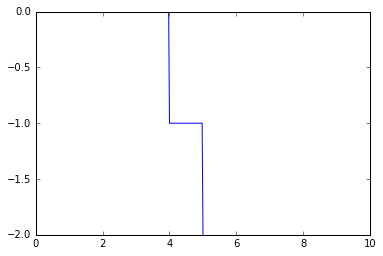

In [303]:
plt.plot(x,u)  ### Sequence of plots?